In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00


In [3]:
import opendatasets as od
import torch
import torchvision
import os
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from einops import rearrange
from einops.layers.torch import Rearrange,Reduce
import torch.nn as nn
import numpy as np
from torchvision.transforms.functional import to_pil_image
from einops import repeat
import torch.nn.functional as F
from torchsummary import summary

In [4]:
od.download('https://www.kaggle.com/datasets/oxcdcd/cifar10')

100%|██████████| 175M/175M [00:01<00:00, 101MB/s]


In [5]:
os.listdir('.')

['.config', 'kaggle.json', 'cifar10', 'sample_data']

In [6]:
data_dir='./cifar10/cifar10/'

In [7]:
stats=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# Stats trained from pretrained ImageNet model
train_tfms=tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.Resize((32,32)),
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)])
valid_tfms=tt.Compose([
    tt.Resize((32,32)),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)]
)

In [8]:
train_ds=ImageFolder(data_dir+'train',train_tfms)
val_ds=ImageFolder(data_dir+'test',valid_tfms)

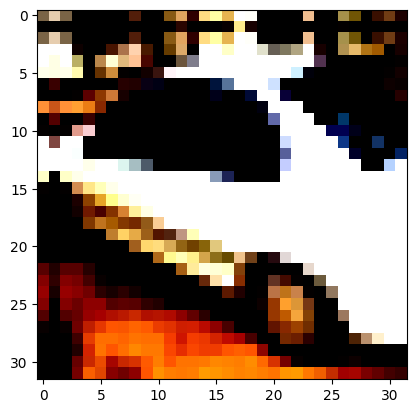

In [9]:
plt.imshow(train_ds[5001][0].permute(1,2,0));

In [10]:
batch_size=32
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
valid_dl=DataLoader(val_ds,batch_size*2,num_workers=3,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def denormalize(image,means,stds):
  means=torch.tensor(means).reshape(1,3,1,1)
  stds=torch.tensor(stds).reshape(1,3,1,1)
  image=image*stds+means
  return image
def show_batch(dl):
  for images,labels in dl:
    fig,ax=plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images=denormalize(images,*stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

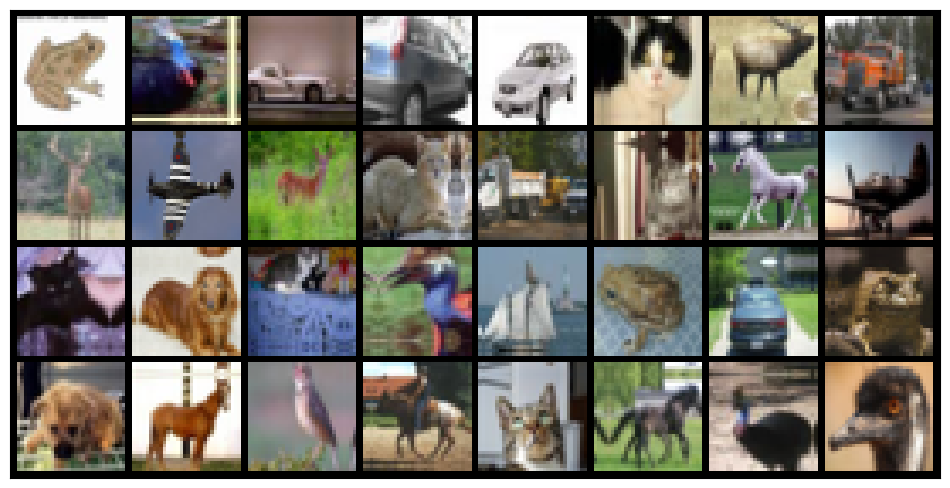

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
     
device=get_default_device()
device

device(type='cuda')

In [14]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(valid_dl,device)

In [15]:
classes=[]
with open(data_dir+'labels.txt','r') as file:
  lines=file.readlines()

for line in lines:
  classes.append(line.strip()) 

In [16]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [17]:
train_ds[1000][1]

0

# Patches Extracter
\

torch.Size([3, 8, 8, 4, 4])


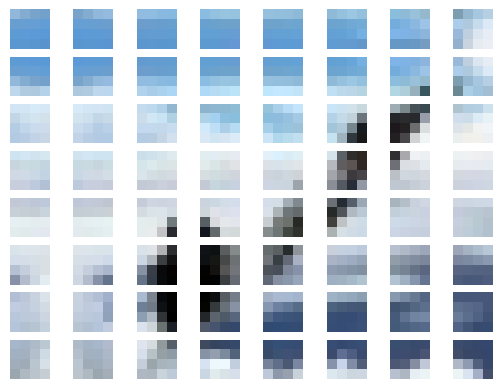

In [18]:
IMG_SIZE = 32
PATCH_SIZE = 4
img=train_ds[1000][0]
patches = img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
print(patches.shape)

fig, ax = plt.subplots(8, 8)
for i in range(8):
    for j in range(8):
        sub_img = patches[:, i, j]
        ax[i][j].imshow(denormalize(sub_img,*stats).squeeze(0).permute(1,2,0));
        ax[i][j].axis('off')

In [19]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 4, emb_size: int = 768,img_size=32):
      self.patch_size = patch_size
      super().__init__()
      self.projection = nn.Sequential(
          # using a conv layer instead of a linear one -> performance gains
          nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
          Rearrange('b e (h) (w) -> b (h w) e')
      )
      self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
      self.position=nn.Parameter(torch.randn((img_size//patch_size)**2+1,emb_size))
                
  def forward(self, x):
    b,_,_,_=x.shape
    x = self.projection(x)
    # cls token added  x batch times and appended 
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
    x = torch.cat([cls_tokens, x], dim=1)
    x+=self.position
    return x

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix

        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x, mask= None) :
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3) # 3 x batch x no_head x sequence_length x emb_size
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [21]:
class ResidualBlock(nn.Module):
  def __init__(self,fn):
    super().__init__()
    self.fn=fn
  
  def forward(self,x,**kwargs):
    res=x
    x=self.fn(x,**kwargs)
    x+=res
    return x

In [22]:
class FeedForward(nn.Sequential):
  def __init__(self,emb_size:int,expansion:int = 4,drop_p:float = 0.):
    super().__init__(
        nn.Linear(emb_size,expansion * emb_size),
        nn.GELU(),
        nn.Dropout(drop_p),
        nn.Linear(expansion * emb_size, emb_size)
    )

In [23]:
class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,emb_size=768,drop_p: float = 0.,forward_expansion: int = 4,forward_drop_p: float = 0.,** kwargs):
    super().__init__(
        ResidualBlock(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size,**kwargs),
            nn.Dropout(drop_p)
        )),
        ResidualBlock(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForward(emb_size,expansion=forward_expansion,drop_p=forward_drop_p),
            nn.Dropout(drop_p)
        )),
    )

In [24]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 6, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [25]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [26]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 4,
                emb_size: int = 768,
                img_size: int = 32,
                depth: int = 6,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [31]:
model=to_device(ViT(),device)

In [36]:
summary(model,(3,32,32),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 8, 8]          37,632
         Rearrange-2              [-1, 64, 768]               0
    PatchEmbedding-3              [-1, 65, 768]               0
         LayerNorm-4              [-1, 65, 768]           1,536
            Linear-5             [-1, 65, 2304]       1,771,776
           Dropout-6            [-1, 8, 65, 65]               0
            Linear-7              [-1, 65, 768]         590,592
MultiHeadAttention-8              [-1, 65, 768]               0
           Dropout-9              [-1, 65, 768]               0
    ResidualBlock-10              [-1, 65, 768]               0
        LayerNorm-11              [-1, 65, 768]           1,536
           Linear-12             [-1, 65, 3072]       2,362,368
             GELU-13             [-1, 65, 3072]               0
          Dropout-14             [-1, 6

In [37]:
for batch in train_dl:
  img,label=batch
  img=img.to(device)
  label=label.to(device)
  out=model(img)
  print(out.shape)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 10])


In [43]:
from tqdm.notebook import tqdm

In [44]:
epochs=2
lr=0.001
opt_func=torch.optim.Adam
criterion=nn.CrossEntropyLoss()
optimizer=opt_func(model.parameters(),lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.7)

In [45]:
def accuracy(outputs,labels):
  _,preds=torch.max(F.softmax(outputs,dim=1),dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [46]:
def fit_one_cycle(epochs,lr_scheduler,model,train_loader,val_loader,optimizer,last_chk_pt=None):
  torch.cuda.empty_cache()
  history=[]
  tr_loss_arr = []
  val_loss_arr = []
  train_acc=[]
  val_acc=[]
  prev_epoch = 0

  if last_chk_pt!=None:
    checkpoint=torch.load(last_chk_pt)
    prev_epoch=checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = to_device(v, device)
          tr_loss_arr =  checkpoint['Training Loss']
    val_loss_arr =  checkpoint['Validation Loss']
    train_acc =  checkpoint['Training Accuracy']
    val_acc =  checkpoint['Validation Accuracy']
    to_device(model, device)
    
  for epoch in range(epochs):
    # Training Phase 
    model.train()

    pbar=tqdm(train_loader,total=len(train_loader))
    for images,labels in pbar:
      images=images.to(device)
      labels=labels.to(device)
      out= model(images)
      loss=criterion(out,labels)
      acc=accuracy(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      tr_loss_arr.append(loss.item())
      train_acc.append(acc)
      pbar.set_postfix({'Epoch':epoch+1+prev_epoch, 
                        'Training Loss': np.mean(tr_loss_arr),
                        'Training Accuracy': np.mean(train_acc),
                        })

    # Validation phase
    with torch.no_grad():

      pbar = tqdm(val_loader, total = len(val_loader))
      images=images.to(device)
      labels=labels.to(device)
      out= model(images)
      loss=criterion(out,labels)
      acc=accuracy(out,labels)
      val_loss_arr.append(loss.item())
      val_acc.append(acc)
      pbar.set_postfix({'Epoch':epoch+1+prev_epoch, 
                        'Validation Loss': np.mean(val_loss_arr),
                        'Validation Accuracy': np.mean(val_acc),
                          })
    checkpoint = {
            'epoch':epoch+1+prev_epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'Training Accuracy': train_acc,
            'Validation Accuracy':val_acc,
        }
    torch.save(checkpoint, f"model_{epoch+1+prev_epoch}.pth")
    lr_scheduler.step()
  return tr_loss_arr, val_loss_arr

In [47]:
history=[fit_one_cycle(epochs,lr_scheduler,model,train_dl,val_dl,optimizer)]

  0%|          | 0/1563 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [50]:
epochs=5

In [51]:
history+=[fit_one_cycle(epochs,lr_scheduler,model,train_dl,val_dl,optimizer)]

  0%|          | 0/1563 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [52]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(torch.softmax(yb,dim=1),dim=1)
    return classes[preds[0].item()]

Label: bird , Predicted: bird


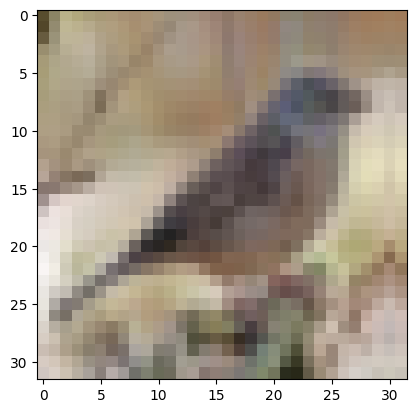

In [53]:
img,label=train_ds[10000]
denorm_img=denormalize(img,*stats)
denorm_img=denorm_img.squeeze(0)
plt.imshow(denorm_img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))